In [35]:
import json
from itertools import chain
from math import ceil

from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

In [36]:
from keras.applications.resnet50 import ResNet50
from keras import losses
from keras.layers import Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization

In [37]:
from keras import Model
from sklearn.model_selection import train_test_split

In [82]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [38]:

datagen = ImageDataGenerator()
gen = datagen.flow_from_directory('images100',
                                  target_size=(224, 224),
                                  class_mode=None, 
                                  shuffle=False,
                                  batch_size=32)

Found 100 images belonging to 1 classes.


In [39]:
num_images = len(gen.filenames)
num_images

100

In [40]:
batches = []
for i in range(ceil(num_images / gen.batch_size)):
    batches.append(gen.next())
    
img_arrays = np.array(list(chain(*batches)))
# img_arrays = np.array(list(chain.from_iterable(batches)))

del batches

In [41]:
img_arrays.shape

(100, 224, 224, 3)

In [42]:
img_ids = np.array([int(fn[6:-4]) for fn in gen.filenames])
img_ids.shape

(100,)

# id-to-labels mapping

In [43]:
with open('data/train.json') as fp:
    train = json.load(fp)
    
df = pd.DataFrame(train['annotations'][:100000])
mlb = MultiLabelBinarizer()
df = df.join(pd.DataFrame(mlb.fit_transform(df['labelId']),
                          columns=mlb.classes_,
                          index=df.index))
df = df.drop('labelId', axis=1)
df.imageId = df.imageId.astype(int)
df = df.set_index('imageId')
df.head()

,1,10,100,101,102,103,104,105,106,107,...,90,91,92,93,94,95,96,97,98,99
imageId,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
df.shape

(100000, 227)

In [45]:
img_labels = df.loc[img_ids]
img_labels.shape

(100, 227)

## arrays size in MB

In [46]:
img_arrays.size * img_arrays.itemsize / 1024**2

57.421875

## Divide train test

In [47]:
training_images, validation_images, training_labels, validation_labels = train_test_split(img_arrays, img_labels)

## Create and modify ResNet model

In [48]:
base_model = ResNet50(weights='imagenet', include_top = False, input_shape=(224, 224, 3))

In [49]:
print(base_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [50]:
label_count=227

In [73]:
x = Flatten()(base_model.output)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
predictions = Dense(label_count, activation = 'sigmoid')(x)

In [74]:
head_model = Model(input = base_model.input, output = predictions)

/home/ubuntu/anaconda2/envs/fashion/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  if __name__ == '__main__':


In [75]:
for layer in head_model.layers[:-4]: 
    layer.trainable=False
    

In [76]:
for layer in head_model.layers: print(layer.trainable)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

In [77]:

head_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## Train last layer of model

In [83]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto')
checkpointer = ModelCheckpoint(filepath="results/best_weights.hdf5", verbose=0, save_best_only=True)

In [87]:
head_model.fit(training_images, training_labels, validation_data=(validation_images, validation_labels), callbacks=[monitor, checkpointer], verbose=2, epochs=10)

Train on 75 samples, validate on 25 samples
Epoch 1/20
 - 33s - loss: 0.7590 - acc: 0.5514 - val_loss: 0.7487 - val_acc: 0.5552
Epoch 2/20
 - 33s - loss: 0.7298 - acc: 0.5649 - val_loss: 0.7055 - val_acc: 0.5776
Epoch 3/20
 - 33s - loss: 0.6971 - acc: 0.5928 - val_loss: 0.6759 - val_acc: 0.6028
Epoch 4/20
 - 33s - loss: 0.6633 - acc: 0.6177 - val_loss: 0.6276 - val_acc: 0.6576
Epoch 5/20
 - 33s - loss: 0.6210 - acc: 0.6549 - val_loss: 0.5793 - val_acc: 0.7168
Epoch 6/20
 - 33s - loss: 0.5690 - acc: 0.7055 - val_loss: 0.5287 - val_acc: 0.7773
Epoch 7/20
 - 33s - loss: 0.5051 - acc: 0.7602 - val_loss: 0.4715 - val_acc: 0.8375
Epoch 8/20
 - 33s - loss: 0.4388 - acc: 0.8221 - val_loss: 0.4242 - val_acc: 0.8710
Epoch 9/20
 - 33s - loss: 0.3689 - acc: 0.8808 - val_loss: 0.3595 - val_acc: 0.9159
Epoch 10/20
 - 34s - loss: 0.2974 - acc: 0.9277 - val_loss: 0.2699 - val_acc: 0.9519
Epoch 11/20
 - 33s - loss: 0.2313 - acc: 0.9655 - val_loss: 0.2094 - val_acc: 0.9642
Epoch 12/20
 - 33s - loss: 0.1

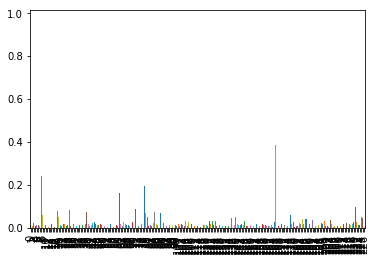

In [104]:
from matplotlib import pyplot as plt
%matplotlib inline

ser = pd.Series(head_model.predict(validation_images[0:1])[0])
ser.plot.bar()

In [98]:
head_model.output_shape

(None, 227)

## Train with more images

### Get Data

In [105]:
datagen = ImageDataGenerator()
gen = datagen.flow_from_directory('images',
                                  target_size=(224, 224),
                                  class_mode=None, 
                                  shuffle=False,
                                  batch_size=32)

Found 100000 images belonging to 1 classes.


In [111]:
# num_images = len(gen.filenames)
num_images = 1000
num_images

1000

In [112]:
%%time
batches = []
for i in range(ceil(num_images / gen.batch_size)):
    batches.append(gen.next())
    
img_arrays = np.array(list(chain(*batches)))
del batches
img_arrays = img_arrays[:num_images]

CPU times: user 4.94 s, sys: 804 ms, total: 5.74 s
Wall time: 5.74 s


In [113]:
img_arrays.shape

(1000, 224, 224, 3)

In [114]:
img_ids = np.array([int(fn[6:-4]) for fn in gen.filenames[:num_images]])
img_ids.shape

(1000,)

In [115]:
with open('data/train.json') as fp:
    train = json.load(fp)
    
df = pd.DataFrame(train['annotations'][:100000])
mlb = MultiLabelBinarizer()
df = df.join(pd.DataFrame(mlb.fit_transform(df['labelId']),
                          columns=mlb.classes_,
                          index=df.index))
df = df.drop('labelId', axis=1)
df.imageId = df.imageId.astype(int)
df = df.set_index('imageId')
df.head()

,1,10,100,101,102,103,104,105,106,107,...,90,91,92,93,94,95,96,97,98,99
imageId,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [116]:
img_labels = df.loc[img_ids]
img_labels.shape

(1000, 227)

### Split to train and validation

In [117]:
training_images, validation_images, training_labels, validation_labels = train_test_split(img_arrays, img_labels)

In [118]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=0, mode='auto')
checkpointer = ModelCheckpoint(filepath="results/best_weights_2.hdf5", verbose=0, save_best_only=True)

In [119]:
head_model.fit(training_images, training_labels, validation_data=(validation_images, validation_labels), callbacks=[monitor, checkpointer], verbose=2, epochs=10)

Train on 750 samples, validate on 250 samples
Epoch 1/10
 - 330s - loss: 0.1033 - acc: 0.9750 - val_loss: 0.1026 - val_acc: 0.9751
Epoch 2/10
 - 330s - loss: 0.0841 - acc: 0.9765 - val_loss: 0.0974 - val_acc: 0.9740
Epoch 3/10
 - 330s - loss: 0.0749 - acc: 0.9774 - val_loss: 0.0945 - val_acc: 0.9756
Epoch 4/10
 - 351s - loss: 0.0685 - acc: 0.9783 - val_loss: 0.0958 - val_acc: 0.9743
Epoch 5/10
 - 352s - loss: 0.0623 - acc: 0.9790 - val_loss: 0.0980 - val_acc: 0.9730
Epoch 6/10
 - 506s - loss: 0.0567 - acc: 0.9802 - val_loss: 0.0980 - val_acc: 0.9740
